In [1]:
'''
# notes 
df["firstname"] = df["Name"].apply(lambda x : x.split(",")[0]) # extract firstname
df["salutation"] = df["Name"].apply(lambda x:x.split(",")[-1].split(".")[0]) # extract salutation e.g: mr,mrs,dr,...
df["lastname"] = df["Name"].apply(lambda x:x.split(",")[-1].split(".")[-1]) # extract last name
df.drop("Name", 1, inplace=True) # already processed
df.head()

df.dropna(subset=["Embarked"], inplace=True)

sns.countplot(x="Sex", hue="Survived", data=df)

#1-hot-encode Pclass
pclass_encoded = pd.get_dummies(df["Pclass"])
pclass_encoded.head()

#sns.boxplot(y="Age",x="SibSp",data=df)
#sns.heatmap(df.corr())
'''
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # disable gpu
# Kaggle setting:
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

import numpy as np
import pandas as pd  
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.callbacks import EarlyStopping # controlling loss

SEED = 111
os.environ['PYTHONHASHSEED'] = str(SEED) # Constant python seed
np.random.seed(SEED) # Constant numpy seed
tf.random.set_seed(SEED) # Constant tensorflow seed

In [2]:
df = pd.read_csv("train.csv")
print(f"Dataset Shape: {df.shape} \n")
print(df.info())
df.head()

Dataset Shape: (891, 12) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
for col in df.columns[1:]:
    print(df[col].value_counts())
    print("----------------------")

df.drop("Ticket", 1, inplace=True) # lots of randomness. seems has no relation to other cols. too many uniques to be 1-hot-encoded
df.drop("Name", 1, inplace=True) # too many uniques to be 1-hot-encoded. can be used in future modellings

df.describe().T # stats of numerical fields

0    549
1    342
Name: Survived, dtype: int64
----------------------
3    491
1    216
2    184
Name: Pclass, dtype: int64
----------------------
Williams, Mr. Howard Hugh "Harry"              1
Gustafsson, Mr. Karl Gideon                    1
Danoff, Mr. Yoto                               1
Peter, Mrs. Catherine (Catherine Rizk)         1
Shorney, Mr. Charles Joseph                    1
                                              ..
LeRoy, Miss. Bertha                            1
Johnson, Mr. Malkolm Joackim                   1
Chibnall, Mrs. (Edith Martha Bowerman)         1
Tobin, Mr. Roger                               1
Clarke, Mrs. Charles V (Ada Maria Winfield)    1
Name: Name, Length: 891, dtype: int64
----------------------
male      577
female    314
Name: Sex, dtype: int64
----------------------
24.00    30
22.00    27
18.00    26
19.00    25
30.00    25
         ..
55.50     1
70.50     1
66.00     1
23.50     1
0.42      1
Name: Age, Length: 88, dtype: int64
----------

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [4]:
# Missing values treatment:
print("% missings in cols:")
print(df.isnull().sum()[df.isnull().sum()>0]/df.shape[0]*100)
print("----------------------")

# 1- drop Cabin as majority of column is empty. Also it seems there's no way to retrieve NAs
df.drop("Cabin", 1, inplace=True) # 
print("droped column Cabin ")

# 2- fill NA of Embarked with its mode
df["Embarked"] = df["Embarked"].fillna(value=df["Embarked"].mode()[0])
print("replaced NA of Embarked with mode")


# 3- fill NA of Age with its median
df["Age"] = df["Age"].fillna(value=df["Age"].median())
#df["Age"][df["SibSp"]==0]=df["Age"][df["SibSp"]==0].fillna(value=df["Age"][df["SibSp"]==0].mean())
#df["Age"][df["SibSp"]==1]=df["Age"][df["SibSp"]==1].fillna(value=df["Age"][df["SibSp"]==1].mean())
#df["Age"][df["SibSp"]==2]=df["Age"][df["SibSp"]==2].fillna(value=df["Age"][df["SibSp"]==2].mean())
#df["Age"][df["SibSp"]==3]=df["Age"][df["SibSp"]==3].fillna(value=df["Age"][df["SibSp"]==3].mean())
#df["Age"][df["SibSp"]==4]=df["Age"][df["SibSp"]==4].fillna(value=df["Age"][df["SibSp"]==4].mean())
#df["Age"][df["SibSp"]==5]=df["Age"][df["SibSp"]==5].fillna(value=df["Age"][df["SibSp"]==5].mean())
#df["Age"] = df["Age"].fillna(value=df["Age"].mean())
print("replaced NA of Age with median")
print("----------------------")


print("% missings in cols:")
print(round(df.isnull().sum()[df.isnull().sum()>0]/df.shape[0]*100),2)
print(f"Dataset Shape: {df.shape} \n")
df.head()

% missings in cols:
Age         19.865320
Cabin       77.104377
Embarked     0.224467
dtype: float64
----------------------
droped column Cabin 
replaced NA of Embarked with mode
replaced NA of Age with median
----------------------
% missings in cols:
Series([], dtype: float64) 2
Dataset Shape: (891, 9) 



,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


In [5]:
# 1-hot-encoding:
# Sex
df["Sex"] = df["Sex"].map({"male":1, "female":0}) # male = 1 / female = 0

# Embarked
embarked_encoded = pd.get_dummies(df["Embarked"])

# Pclass
#pclass_encoded = pd.get_dummies(df["Pclass"],prefix="class_")

#df.drop(["Embarked","Pclass"],axis=1,inplace=True) # drop uncoded cols
#df = pd.concat([df,embarked_encoded,pclass_encoded],axis=1) # concat encoded ones
df.drop(["Embarked"],axis=1,inplace=True) # drop uncoded cols
df = pd.concat([df,embarked_encoded],axis=1) # concat encoded ones

# shuffle data
df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)

# save data file
df.to_csv('df_v1.csv',index=False)
print(f"Dataset Shape: {df.shape} \n")
df.head()

Dataset Shape: (891, 11) 



,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
0,375,0,3,0,3.0,3,1,21.0750,0,0,1
1,212,1,2,0,35.0,0,0,21.0000,0,0,1
2,259,1,1,0,35.0,0,0,512.3292,1,0,0
3,585,0,3,1,28.0,0,0,8.7125,1,0,0
4,462,0,3,1,34.0,0,0,8.0500,0,0,1


In [6]:
#modeling:
df_v1 = pd.read_csv("df_v1.csv")

# Features & Labels
X1 = df_v1.drop(["PassengerId", "Survived"], axis=1).values
y1 = df_v1["Survived"].values

# train/test split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.1
                                                        , random_state=SEED
                                                       )
print(f"shapes: X1_train:{X1_train.shape}, X1_test:{X1_test.shape}, y1_train:{y1_train.shape}, y1_test:{y1_test.shape}")

# scaling
scaler = MinMaxScaler()
scaler.fit(X1_train)
X1_train_s = scaler.transform(X1_train)
X1_test_s = scaler.transform(X1_test)

# model
def build_model():
    model = Sequential()
    
    model.add(Dense(units=5, activation='relu'))
    model.add(Dropout(0.5))
     
    model.add(Dense(units=5, activation='relu'))
    model.add(Dropout(0.5))
   
    '''
    model.add(Dense(units=25, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(units=17, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(units=9, activation='relu'))
    model.add(Dropout(0.5))
    '''
    
    model.add(Dense(units=1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

dnnClf = build_model()

# early stopping callback
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=32)

shapes: X1_train:(801, 9), X1_test:(90, 9), y1_train:(801,), y1_test:(90,)


In [7]:
dnnClf.fit(x=X1_train_s, y=y1_train,epochs=1000, validation_data=(X1_test_s,y1_test),
                   callbacks=[early_stop]
)

Train on 801 samples, validate on 90 samples
Epoch 1/1000
801/801 [==============================] - 2s 2ms/sample - loss: 0.7721 - accuracy: 0.5094 - val_loss: 0.6859 - val_accuracy: 0.5778
Epoch 2/1000
801/801 [==============================] - 0s 176us/sample - loss: 0.7395 - accuracy: 0.5793 - val_loss: 0.6741 - val_accuracy: 0.5444
Epoch 3/1000
801/801 [==============================] - 0s 176us/sample - loss: 0.7095 - accuracy: 0.6092 - val_loss: 0.6655 - val_accuracy: 0.7000
Epoch 4/1000
801/801 [==============================] - 0s 174us/sample - loss: 0.6825 - accuracy: 0.6467 - val_loss: 0.6587 - val_accuracy: 0.6333
Epoch 5/1000
801/801 [==============================] - 0s 179us/sample - loss: 0.6726 - accuracy: 0.6504 - val_loss: 0.6562 - val_accuracy: 0.6556
Epoch 6/1000
801/801 [==============================] - 0s 182us/sample - loss: 0.6681 - accuracy: 0.6729 - val_loss: 0.6515 - val_accuracy: 0.6778
Epoch 7/1000
801/801 [==============================] - 0s 173us/samp

Max. val_accuracy:  0.8333333134651184


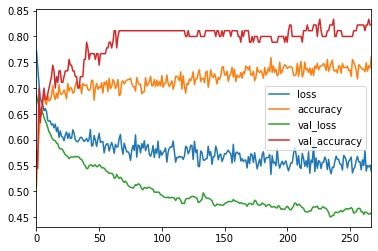

In [8]:
model_loss_df = pd.DataFrame(dnnClf.history.history)
print("Max. val_accuracy: ", model_loss_df["val_accuracy"].max())
model_loss_df.plot()

### SVM:

In [9]:
svmClf = SVC(kernel="linear")
svmClf.fit(X1_train,y1_train)
svmPreds = svmClf.predict(X1_test)
svmAcc = metrics.accuracy_score(svmPreds, y1_test)
print("SVM Accuracy:",round(svmAcc,3))

SVM Accuracy: 0.833


### RandomForest:

In [10]:
rfClf = RandomForestRegressor(n_estimators = 200)
rfClf.fit(X1_train, y1_train)
rfPreds = rfClf.predict(X1_test)
rfPreds = [round(i) for i in rfPreds]
rfAcc = metrics.accuracy_score(rfPreds,y1_test)
print("RF Accuracy:",round(rfAcc,3))

RF Accuracy: 0.833


### GradientBoost:

In [11]:
xgbClf = XGBClassifier(n_estimators=400)
xgbClf.fit(X1_train, y1_train)
xgbPreds = xgbClf.predict(X1_test)
xgbAcc = metrics.accuracy_score(xgbPreds,y1_test)
print("XGB Accuracy:",round(xgbAcc,3))

XGB Accuracy: 0.811


### LogisticRegression:

In [12]:
lrClf = LogisticRegression(solver="newton-cg")
lrClf.fit(X1_train, y1_train)
lrPreds = lrClf.predict(X1_test)
lrAcc = metrics.accuracy_score(lrPreds,y1_test)
print("LogisticsRegression Accuracy:",round(lrAcc,3))

LogisticsRegression Accuracy: 0.822


### Prediction on Submission File :
#### Ensemble Method: Combining all models

In [16]:
def predictEnsemble(sample):
    print("=",end="")
    dnnPred = dnnClf.predict(scaler.transform(sample.reshape(1,-1))).tolist()[0][0]
    svmPred = svmClf.predict(sample.reshape(1,-1)).tolist()[0]
    rfPred = rfClf.predict(sample.reshape(1,-1)).tolist()[0]
    xgbPred = xgbClf.predict(sample.reshape(1,-1)).tolist()[0]
    lrPred = lrClf.predict(sample.reshape(1,-1)).tolist()[0]

    ensPred = []
    ensPred.append([dnnPred, svmPred, rfPred, xgbPred, lrPred])


    print(ensPred)
    ensPred = [round(i) for i in ensPred[0]]
    print(ensPred)
    
    print(max(set(ensPred), key=ensPred.count))
    return(max(set(ensPred), key=ensPred.count)) # return mode, i.e: most frequent



In [17]:
test_df = pd.read_csv("test.csv")

test_df.drop("Ticket", 1, inplace=True)
test_df.drop("Name", 1, inplace=True)
test_df.drop("Cabin", 1, inplace=True)

test_df["Embarked"] = test_df["Embarked"].fillna(value=test_df["Embarked"].mode()[0])
test_df["Age"] = test_df["Age"].fillna(value=test_df["Age"].median())
test_df["Fare"] = test_df["Fare"].fillna(value=test_df["Fare"].median())


test_df["Sex"] = test_df["Sex"].map({"male":1, "female":0})
test_embarked_encoded = pd.get_dummies(test_df["Embarked"])
#test_pclass_encoded = pd.get_dummies(test_df["Pclass"], prefix="class_")
test_pclass_encoded = pd.get_dummies(test_df["Pclass"], prefix="class_")
#test_df.drop(["Embarked","Pclass"],axis=1,inplace=True)
test_df.drop(["Embarked"],axis=1,inplace=True)
#test_df = pd.concat([test_df,test_embarked_encoded,test_pclass_encoded],axis=1)
test_df = pd.concat([test_df,test_embarked_encoded],axis=1)

print(f"test_df Shape: {test_df.shape} \n")

test_df.head()

test_df Shape: (418, 10) 



,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
0,892,3,1,34.5,0,0,7.8292,0,1,0
1,893,3,0,47.0,1,0,7.0000,0,0,1
2,894,2,1,62.0,0,0,9.6875,0,1,0
3,895,3,1,27.0,0,0,8.6625,0,0,1
4,896,3,0,22.0,1,1,12.2875,0,0,1


In [18]:
X_TEST = test_df.drop("PassengerId", axis=1).values

preds = []
for e in X_TEST:
    preds.append(predictEnsemble(e))

submit = pd.DataFrame(data={"PassengerId":test_df["PassengerId"].tolist(), "Survived":preds})

submit.to_csv('submit.csv',index=False)
submit.head()

=[[0.25201478600502014, 0, 0.03177777777777777, 0, 0]]
[0, 0, 0, 0, 0]
0
=[[0.3832395076751709, 1, 0.19, 0, 0]]
[0, 1, 0, 0, 0]
0
=[[0.2638761103153229, 0, 0.59, 0, 0]]
[0, 0, 1, 0, 0]
0
=[[0.2552781403064728, 0, 0.66, 0, 0]]
[0, 0, 1, 0, 0]
0
=[[0.35398104786872864, 1, 0.385, 0, 1]]
[0, 1, 0, 0, 1]
0
=[[0.2566032111644745, 0, 0.08333333333333331, 0, 0]]
[0, 0, 0, 0, 0]
0
=[[0.5274186730384827, 1, 0.135, 0, 1]]
[1, 1, 0, 0, 1]
1
=[[0.279599130153656, 0, 0.18333333333333335, 0, 0]]
[0, 0, 0, 0, 0]
0
=[[0.45797213912010193, 1, 0.885, 1, 1]]
[0, 1, 1, 1, 1]
1
=[[0.25413021445274353, 0, 0.045, 0, 0]]
[0, 0, 0, 0, 0]
0
=[[0.25518059730529785, 0, 0.085, 0, 0]]
[0, 0, 0, 0, 0]
0
=[[0.2850878834724426, 0, 0.18, 0, 0]]
[0, 0, 0, 0, 0]
0
=[[0.8753798007965088, 1, 1.0, 1, 1]]
[1, 1, 1, 1, 1]
1
=[[0.26652032136917114, 0, 0.365, 0, 0]]
[0, 0, 0, 0, 0]
0
=[[0.8879660367965698, 1, 1.0, 1, 1]]
[1, 1, 1, 1, 1]
1
=[[0.8802921175956726, 1, 0.8129166666666667, 1, 1]]
[1, 1, 1, 1, 1]
1
=[[0.266888409852981

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
